<a href="https://colab.research.google.com/github/YT1202/DSP-Introduction/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jan  8 14:33:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import time
import scipy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten
from keras.layers import Dropout
from scipy import signal

In [3]:
# 計時開始
tStart = time.time()

In [4]:
# Step_1 載入資料集  
sample, label = np.load("traindata.npy"), np.load("trainlabel.npy")
val_sample, val_label = np.load("validationdata.npy"), np.load("validationlabel.npy")
test_sample = np.load("testdata.npy")
print("Train size: ", sample.shape)
print("Train target: ", label.shape, "\n-------------------------------------")
print("Val size: ", val_sample.shape)
print("Val target: ", val_label.shape, "\n-------------------------------------")
print("Test size: ", test_sample.shape, "\n=======================================")

Train size:  (3360, 2, 20000)
Train target:  (3360,) 
-------------------------------------
Val size:  (480, 2, 20000)
Val target:  (480,) 
-------------------------------------
Test size:  (960, 2, 20000) 


Spec size:  (3360, 2, 129, 158) 
-------------------------------------
Val_Spec size:  (480, 2, 129, 158) 
-------------------------------------
Test_Spec size:  (960, 2, 129, 158) 
-------------------------------------
x_train size:  (3360, 2, 129, 158) 
-------------------------------------
x_val size:  (480, 2, 129, 158) 
-------------------------------------
x_test size:  (960, 2, 129, 158) 


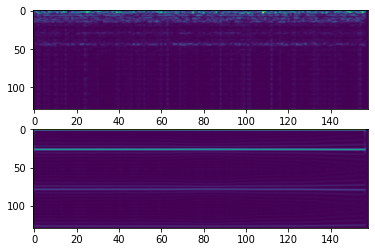

In [5]:
# Step_2  時頻分析
f, t, spec = signal.stft(sample, fs = 16000)
f, t, val_spec = signal.stft(val_sample, fs = 16000)
f, t, test_spec = signal.stft(test_sample, fs = 16000)
print("Spec size: ", spec.shape, "\n-------------------------------------")
print("Val_Spec size: ", val_spec.shape, "\n-------------------------------------")
print("Test_Spec size: ", test_spec.shape, "\n-------------------------------------")
x_train = np.abs(spec.reshape(-1, 2, 129, 158))
x_val = np.abs(val_spec.reshape(-1, 2, 129, 158))
x_test = np.abs(test_spec.reshape(-1, 2, 129, 158))
print("x_train size: ", x_train.shape, "\n-------------------------------------")
print("x_val size: ",x_val.shape, "\n-------------------------------------")
print("x_test size: ", x_test.shape, "\n=======================================")

plt.subplot(2,1,1)
plt.imshow(x_train[0][0], aspect='auto')
plt.subplot(2,1,2)
plt.imshow(x_train[0][1], aspect='auto')

In [6]:
# Step_3  利用OneHot對label進行編碼
y_train = label
y_val = val_label

y_train_onehot = np_utils.to_categorical(y_train)
y_val_onehot = np_utils.to_categorical(y_val)

In [7]:
# Step_4  建立訓練模型
model = Sequential()

# Conv layer 1 output shape (6, 129, 158)

model.add(Convolution2D(
    batch_input_shape=(None, 2, 129, 158),
    filters=6,
    kernel_size=5,
    strides=1,
    padding='same',     # Padding method
    data_format='channels_first',
    activation='relu'))

# Pooling layer 1 (max pooling) output shape (6, 65, 79)
model.add(MaxPooling2D(
     pool_size=2,
     strides=2,
     padding='same',
     data_format='channels_first'))

# Conv layer 2 output shape (16, 65, 79)
model.add(Convolution2D(filters=16, 
            kernel_size=5, 
            strides=1, 
            padding='same',
            data_format='channels_first', 
            activation='relu'))

# Pooling layer 2 (max pooling) output shape (16, 33, 40)
model.add(MaxPooling2D(
     pool_size=2,
     strides=2,
     padding='same',
     data_format='channels_first'))

# Conv layer 3 output shape (16, 33, 40)
model.add(Convolution2D(filters=16, 
            kernel_size=5, 
            strides=1, 
            padding='same',
            data_format='channels_first', 
            activation='relu'))

# Pooling layer 3 (max pooling) output shape (16, 17, 20)
model.add(MaxPooling2D(
     pool_size=2,
     strides=2,
     padding='same',
     data_format='channels_first'))

# Conv layer 4 output shape (36, 17, 20)
model.add(Convolution2D(filters=36, 
            kernel_size=5, 
            strides=1, 
            padding='same',
            data_format='channels_first', 
            activation='relu'))

# Pooling layer 4 (max pooling) output shape (36, 9, 10)
model.add(MaxPooling2D(
     pool_size=2,
     strides=2,
     padding='same',
     data_format='channels_first'))

# Conv layer 5 output shape (48, 9, 10)
model.add(Convolution2D(filters=48, 
            kernel_size=5, 
            strides=1, 
            padding='same',
            data_format='channels_first', 
            activation='relu'))

# Pooling layer 5 (max pooling) output shape (48, 5, 5)
model.add(MaxPooling2D(
     pool_size=2,
     strides=2,
     padding='same',
     data_format='channels_first'))

model.add(Dropout(0.25))

# Fc layer 1 input shape (48 * 5 * 5) = (1200), output shape (1024)
model.add(Flatten())
model.add(Dense(units=1024, 
        activation='relu'))
model.add(Dropout(0.5))
# Fc layer 2 input shape (1024), output shape (128)
model.add(Dense(units=128,  
        activation='relu'))
model.add(Dropout(0.5))
# Output
model.add(Dense(units=4,  
        activation='softmax'))
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 129, 158)       306       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 65, 79)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 65, 79)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 33, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 33, 40)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 17, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 17, 20)        1

In [8]:
# Step_4  參數設定
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

train_history=model.fit(x=x_train, 
            y=y_train_onehot,
            validation_data=(x_val, y_val_onehot), 
            epochs=10, 
            batch_size=64,
            verbose=2)

Epoch 1/10
53/53 - 9s - loss: 1.3884 - accuracy: 0.2545 - val_loss: 1.3863 - val_accuracy: 0.2625
Epoch 2/10
53/53 - 1s - loss: 1.3871 - accuracy: 0.2435 - val_loss: 1.3863 - val_accuracy: 0.2354
Epoch 3/10
53/53 - 1s - loss: 1.3853 - accuracy: 0.2714 - val_loss: 1.3861 - val_accuracy: 0.2896
Epoch 4/10
53/53 - 1s - loss: 1.3841 - accuracy: 0.2702 - val_loss: 1.3819 - val_accuracy: 0.2833
Epoch 5/10
53/53 - 1s - loss: 1.3816 - accuracy: 0.2679 - val_loss: 1.3814 - val_accuracy: 0.2333
Epoch 6/10
53/53 - 1s - loss: 1.3806 - accuracy: 0.2783 - val_loss: 1.3803 - val_accuracy: 0.2083
Epoch 7/10
53/53 - 1s - loss: 1.1528 - accuracy: 0.4241 - val_loss: 0.6568 - val_accuracy: 0.7104
Epoch 8/10
53/53 - 1s - loss: 0.5298 - accuracy: 0.7673 - val_loss: 0.4739 - val_accuracy: 0.7854
Epoch 9/10
53/53 - 1s - loss: 0.3551 - accuracy: 0.8685 - val_loss: 0.3150 - val_accuracy: 0.8750
Epoch 10/10
53/53 - 1s - loss: 0.2299 - accuracy: 0.9182 - val_loss: 0.2257 - val_accuracy: 0.9208


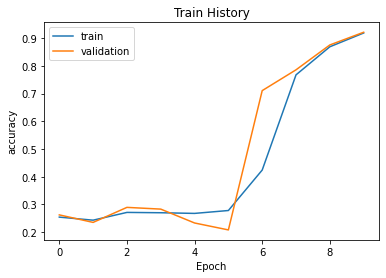

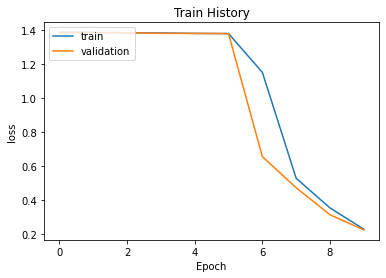

In [9]:
# Step_5  顯示訓練結果: Accurancy & Loss
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

In [10]:
# Step_6 儲存模型
model.save('model.h5') 

In [11]:
# Step_7  用測試集檢驗模型
scores = model.evaluate(x_val, y_val_onehot)
print('accurancy= ', scores[1])

15/15 [==============================] - 0s 5ms/step - loss: 0.2257 - accuracy: 0.9208
accurancy=  0.9208333492279053


In [12]:
# Step_8  利用訓練好的模型驗證
prediction = model.predict_classes(x_test)
y_test = prediction.reshape(-1,1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [15]:
# Step_9  產生繳交csv格式 
id_test = np.array(range(0, 960)).reshape(-1,1)
submission = np.hstack([id_test, y_test])
submission = pd.DataFrame(submission, columns=["id", "category"])

submission.to_csv('submission.csv', sep=',', index=False)

In [14]:
# 計時結束
tEnd = time.time()
print('==========================================\ntime : ', tEnd - tStart, '(s)')

time :  51.64838099479675 (s)
